In [13]:
# Gibeom Lee, HI Lab
# 이 코드는 AC의 frequency 를 측정해주는 코드입니다.
#

In [14]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

In [ ]:
# 1. 사용자 입력값
file_path = r"C:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\3. Material selection\250802_flat 비교 및 dodecane 재평가\minimized_csv파일\Dodecane\고주파수\A_Dodecane_2cm_12Hz.csv"

# 설정값
prominence_ratio = 0.3 # 신호의 표준편차(std)에 곱해 피크 prominence 기준을 설정 / 주변 값보다 얼마나 돌출된 정도여야 피크로 인식할지를 결정
min_prominence = 0.1 # prominence의 최솟값 제한 / std가 너무 작아서 prominence가 너무 낮게 계산되는 경우를 방지
min_distance_sec = 0.1 #인접한 피크 간 최소 시간 간격 (초 단위)
snr_threshold = 1 # Signal-to-Noise Ratio 기준값 / 값이 높을수록 강한 피크만 통과
min_relative_height = 0.1  # 전체 최대 진폭의 20% 이상

📊 샘플링 속도: 1000.09 Hz
🔁 평균 주파수: 1.85 Hz
✔ 최종 피크 수: 18


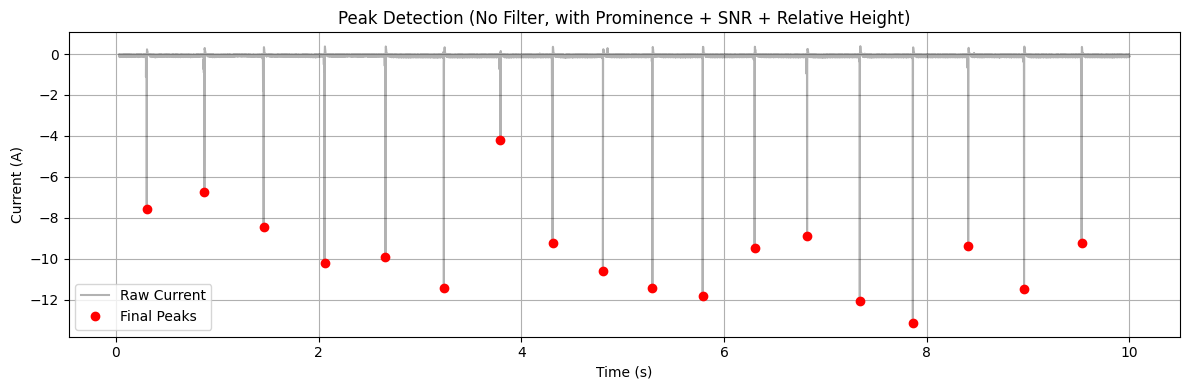

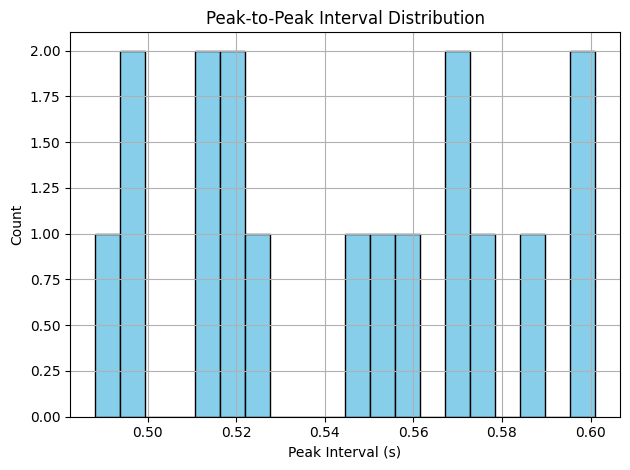

In [16]:
# -------------------------------
# 2. CSV 로딩 및 샘플링 정보
df = pd.read_csv(file_path, header=None, names=["Time", "Current"], skiprows=30)
time = df["Time"].values
current = df["Current"].values

total_time = time[-1] - time[0]
sampling_rate = len(time) / total_time
print(f"📊 샘플링 속도: {sampling_rate:.2f} Hz")

# -------------------------------
# 4. 피크 후보 검출 (음의 피크)
prom = max(np.std(current) * prominence_ratio, min_prominence)
distance = int(sampling_rate * min_distance_sec)
raw_peaks, properties = find_peaks(-current, prominence=prom, distance=distance)

# -------------------------------
# 5. SNR + 상대 진폭 필터링
max_amplitude = np.max(-current)
final_peaks = []
for i in raw_peaks:
    left = max(0, i - int(0.05 * sampling_rate))
    right = min(len(current), i + int(0.05 * sampling_rate))
    local_noise = max(np.std(current[left:right]), 1e-6)
    signal = -current[i]
    if signal > max_amplitude * min_relative_height and signal / local_noise > snr_threshold:
        final_peaks.append(i)

final_peaks = np.array(final_peaks, dtype=int)
peak_times = time[final_peaks]

# -------------------------------
# 6. 주파수 계산
if len(peak_times) < 2:
    mean_freq = 0
    print("⚠ 유효한 피크 수 부족. 주파수 계산 불가.")
else:
    periods = np.diff(peak_times)
    mean_freq = np.mean(1 / periods)
    print(f"🔁 평균 주파수: {mean_freq:.2f} Hz")
    print(f"✔ 최종 피크 수: {len(final_peaks)}")

# -------------------------------
# 7. 시각화
plt.figure(figsize=(12, 4))
plt.plot(time, current, label='Raw Current', color='black', alpha=0.3)
plt.plot(time[final_peaks], current[final_peaks], 'ro', label='Final Peaks')
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("Peak Detection (No Filter, with Prominence + SNR + Relative Height)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 8. 피크 간격 히스토그램
if len(final_peaks) > 1:
    plt.figure()
    plt.hist(np.diff(time[final_peaks]), bins=20, color='skyblue', edgecolor='k')
    plt.xlabel("Peak Interval (s)")
    plt.ylabel("Count")
    plt.title("Peak-to-Peak Interval Distribution")
    plt.grid(True)
    plt.tight_layout()
    plt.show()